In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# 1) 데이터셋 로드 & 분할
# ──────────────────────────────────────────────────────────────────────────────
raw = torch.load('/content/drive/MyDrive/DEAM_dataset_cleaned.pt')

# dict with keys 'spectrograms', 'annotations', 'song_ids'
clean_specs = raw['spectrograms']   # Tensor list or Tensor of shape (N,1,128,60)
clean_anns  = raw['annotations']    # Tensor list or Tensor of shape (N,60,2)
clean_ids   = raw['song_ids']       # list or Tensor of shape (N,)

# make sure they're all the same length N
N = len(clean_ids)

# build unified list of dicts
data_list = []
for i in range(N):
    song_id = int(clean_ids[i])

    spec    = clean_specs[i]   # Tensor[1,128,60]
    ann     = clean_anns[i]    # Tensor[60,2]
    data_list.append({'song_id': song_id, 'spec': spec, 'ann': ann})


In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# 2) Train/Val/Test 데이터 분할 (정규화 포함)
# ──────────────────────────────────────────────────────────────────────────────

# Step 1: song_id를 기준으로 데이터 아이템을 train/val과 test용으로 먼저 분리합니다.
train_val_ids = {d['song_id'] for d in data_list if d['song_id'] <= 2000}
test_ids      = {d['song_id'] for d in data_list if d['song_id']  > 2000}

train_val_items = [d for d in data_list if d['song_id'] in train_val_ids]
test_items      = [d for d in data_list if d['song_id'] in test_ids]

# Step 2: train_val_items를 train과 validation용으로 다시 분할합니다.
#         random_split을 사용하기 위해 임시 Dataset을 만듭니다.
class TempDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, idx): return self.items[idx]

val_ratio = 0.1
temp_ds = TempDataset(train_val_items)
val_size = int(len(temp_ds) * val_ratio)
train_size = len(temp_ds) - val_size

train_subset, val_subset = random_split(
    temp_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# 분할된 subset에서 실제 데이터 아이템 리스트를 다시 추출합니다.
train_items = [item for item in train_subset]
val_items   = [item for item in val_subset]


# Step 3: ★★★ 오직 Train 데이터셋의 스펙트로그램으로만 평균과 표준편차를 계산합니다. ★★★
print("학습 데이터셋에서 정규화 통계치 계산 중...")
train_specs = torch.cat([d['spec'] for d in train_items], dim=0) # 모든 스펙트로그램을 배치 차원으로 연결
mean = train_specs.mean()
std = train_specs.std()

print(f"  - 계산된 Mean: {mean:.4f}")
print(f"  - 계산된 Std Dev: {std:.4f}")
# 이 값을 저장해두면 나중에 추론 시에도 사용할 수 있습니다.
torch.save({'mean': mean, 'std': std}, 'norm_stats.pt')


# Step 4: 계산된 통계치(mean, std)를 모든 데이터에 적용합니다.
#         (메모리 절약을 위해 in-place로 연산)
def normalize_items(items, mean, std):
    for item in items:
        item['spec'] = (item['spec'] - mean) / (std + 1e-8) # 0으로 나누는 것을 방지
    return items

train_items = normalize_items(train_items, mean, std)
val_items   = normalize_items(val_items, mean, std)
test_items  = normalize_items(test_items, mean, std)
print("모든 데이터셋(Train/Val/Test)에 정규화를 적용했습니다.")


# Step 5: 최종 PyTorch Dataset을 생성합니다.
class DEAMDataset(Dataset):
    def __init__(self, items):
        self.samples = items
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        # 데이터가 이미 정규화되었으므로 그대로 반환
        return self.samples[idx]['spec'], self.samples[idx]['ann']

train_ds = DEAMDataset(train_items)
val_ds   = DEAMDataset(val_items)
test_ds  = DEAMDataset(test_items)

print(f"\n데이터셋 준비 완료:")
print(f"  - Train: {len(train_ds)} 샘플")
print(f"  - Validation: {len(val_ds)} 샘플")
print(f"  - Test: {len(test_ds)} 샘플")


학습 데이터셋에서 정규화 통계치 계산 중...
  - 계산된 Mean: -47.9824
  - 계산된 Std Dev: 19.8544
모든 데이터셋(Train/Val/Test)에 정규화를 적용했습니다.

데이터셋 준비 완료:
  - Train: 1570 샘플
  - Validation: 174 샘플
  - Test: 58 샘플


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) DataLoader
# ──────────────────────────────────────────────────────────────────────────────
batch_size  = 16
num_workers = 2

train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [ ]:
def safe_collate(batch):
    # batch: list of (spec,ann)
    specs, anns = zip(*batch)
    # 각 원소를 반드시 clone() 하여 독립 스토리지 확보
    specs = [torch.as_tensor(s, dtype=torch.float32).clone() for s in specs]
    anns  = [torch.as_tensor(a, dtype=torch.float32).clone() for a in anns]
    return torch.stack(specs, 0), torch.stack(anns, 0)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, collate_fn=safe_collate)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Concordance Correlation Coefficient 정의
# ──────────────────────────────────────────────────────────────────────────────
def concordance_correlation_coefficient(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    true_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var = np.var(y_true)
    pred_var = np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)


# ──────────────────────────────────────────────────────────────────────────────
# [추가] CCC Loss 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
class CCCLoss(nn.Module):
    def __init__(self):
        super(CCCLoss, self).__init__()

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Concordance Correlation Coefficient (CCC) Loss.
        - y_pred: 예측값, shape = [B, T, 2]
        - y_true: 실제값, shape = [B, T, 2]
        """
        # Valence와 Arousal을 분리
        y_true_v = y_true[..., 0]
        y_pred_v = y_pred[..., 0]
        y_true_a = y_true[..., 1]
        y_pred_a = y_pred[..., 1]

        # 각 차원에 대해 CCC 계산
        ccc_v = self._ccc_metric(y_pred_v, y_true_v)
        ccc_a = self._ccc_metric(y_pred_a, y_true_a)

        # CCC는 클수록 좋으므로, (1 - CCC)를 손실로 사용 (작을수록 좋게 만듬)
        # 두 차원의 손실을 평균내어 반환
        return ( (1 - ccc_v) + (1 - ccc_a) ) / 2

    def _ccc_metric(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        # 텐서를 1차원으로 펼침
        y_true_flat = y_true.view(-1)
        y_pred_flat = y_pred.view(-1)

        # 평균 계산
        mean_true = torch.mean(y_true_flat)
        mean_pred = torch.mean(y_pred_flat)

        # 분산 계산
        var_true = torch.var(y_true_flat)
        var_pred = torch.var(y_pred_flat)

        # 공분산 계산
        covariance = torch.mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))

        # 분모가 0이 되는 것을 방지하기 위한 작은 값 (epsilon)
        epsilon = 1e-8

        # CCC 공식 적용
        ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2 + epsilon)

        return ccc

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 (CNN + Transformer) - 수정된 버전
# ──────────────────────────────────────────────────────────────────────────────

class FeatureExtractorCNN(nn.Module):
    """
    [수정] CNN의 역할을 정보 압축이 아닌 '풍부한 특징 추출'로 변경합니다.
    - 최종 출력은 (B, 60, 128) 모양의 특징 시퀀스가 됩니다.
    """
    def __init__(self, dropout_cfg=(0.3,0.3,0.4,0.4), negative_slope=0.8):
        super().__init__()
        d1,d2,d3,d4 = dropout_cfg
        nl = negative_slope

        # Block1: (B, 1, 128, 60) -> (B, 16, 64, 60)
        self.block1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(16,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d1),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block2: (B, 16, 64, 60) -> (B, 32, 32, 60)
        self.block2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d2),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block3: (B, 32, 32, 60) -> (B, 64, 16, 60)
        self.block3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d3),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block4: (B, 64, 16, 60) -> (B, 128, 1, 60)
        self.block4 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d4),
            nn.MaxPool2d((2,1),stride=(2,1)),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.MaxPool2d((8,1),stride=(8,1)),
        )
        # [삭제] 정보를 압축하던 마지막 Conv2d 레이어를 제거합니다.
        # self.conv_out = nn.Conv2d(128,2,1)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)   # → [B, 128, 1, 60]

        # [수정] Transformer가 입력받기 좋은 형태로 모양을 변경합니다.
        # [B, 128, 1, 60] -> [B, 128, 60] -> [B, 60, 128]
        x = x.squeeze(2)
        return x.permute(0,2,1)


class PositionalEncoding(nn.Module): # (이전과 동일)
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:,:x.size(1),:]


class EmotionModel2(nn.Module):
    """
    [수정] CNN과 Transformer를 올바르게 결합한 새로운 모델 클래스입니다.
    """
    def __init__(self,
                 cnn: nn.Module,
                 d_model: int = 128,  # CNN의 출력 차원과 동일해야 함
                 nhead: int = 8,
                 num_layers: int = 4,
                 dim_feedforward: int = 512,
                 dropout: float = 0.4,
                 seq_len: int = 60):
        super().__init__()
        self.cnn = cnn
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu',
            batch_first=True  # [수정] batch_first=True로 설정하여 (B, T, D) 입력을 처리
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2) # 최종 출력은 2 (Valence, Arousal)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        feat = self.cnn(x)          # → [B, 60, 128] (풍부한 특징 시퀀스)
        seq  = self.pos_encoder(feat) # → [B, 60, 128]
        seq  = self.transformer(seq)  # → [B, 60, 128] (시간적 패턴 학습)

        # 최종적으로 각 시간 스텝별로 Valence, Arousal 예측
        return torch.tanh(self.regressor(seq)) # → [B, 60, 2]

In [ ]:
# MK4
# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_cnn = FeatureExtractorCNN()
model = EmotionModel2(base_cnn).to(device)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) Optimizer / Scheduler / Loss 설정 - 하이브리드 Loss 버전
# ──────────────────────────────────────────────────────────────────────────────
total_params = sum(p.numel() for p in model.parameters())
trainable   = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total: {total_params:,}개, Trainable: {trainable:,}개")

lr, weight_decay = 5e-4, 1e-6
optimizer   = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler   = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
early_stop_patience = 15 # Early stopping도 여유있게 늘려줍니다.

mse_criterion = nn.MSELoss()
ccc_criterion = CCCLoss()

Total: 1,235,378개, Trainable: 1,235,378개


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) TRAIN / VAL 루프 - 하이브리드 Loss 버전
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss      = float('inf')
early_stop_counter = 0
history = {
    'train_loss': [], 'val_loss': [], 'mse': [], 'ccc_val': [],
    'ccc_aro': [], 'r2_val': [], 'r2_aro': []
}

for epoch in range(1, 101):
    # -- TRAIN --
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad()
        out = model(spec)

        # [수정] 하이브리드 손실 계산
        loss_mse = mse_criterion(out, ann)
        loss_ccc = ccc_criterion(out, ann)
        loss = 0.8 * loss_mse + 0.2 * loss_ccc # 두 손실을 1:1 비율로 합산

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    # -- VALIDATION --
    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)

            # [수정] 검증 루프에서도 동일하게 하이브리드 손실을 계산
            loss_mse = mse_criterion(out, ann)
            loss_ccc = ccc_criterion(out, ann)
            val_loss_step = 0.5 * loss_mse + 0.5 * loss_ccc
            val_loss += val_loss_step.item() * spec.size(0)

            all_preds.append(out.cpu().numpy().reshape(-1,2))
            all_trues.append(ann.cpu().numpy().reshape(-1,2))
    val_loss /= len(val_loader.dataset)

    # --- 이하 지표 계산 및 출력, EarlyStopping 로직은 이전과 동일합니다 ---
    preds = np.vstack(all_preds)
    trues = np.vstack(all_trues)
    mse     = np.mean((preds-trues)**2)
    mae     = np.mean(np.abs(preds-trues))
    r_val   = np.corrcoef(trues[:,0],preds[:,0])[0,1]
    r_aro   = np.corrcoef(trues[:,1],preds[:,1])[0,1]
    r2_val  = r2_score(trues[:,0],preds[:,0])
    r2_aro  = r2_score(trues[:,1],preds[:,1])
    ccc_val = concordance_correlation_coefficient(trues[:,0],preds[:,0])
    ccc_aro = concordance_correlation_coefficient(trues[:,1],preds[:,1])

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mse'].append(mse)
    history['ccc_val'].append(ccc_val)
    history['ccc_aro'].append(ccc_aro)
    history['r2_val'].append(r2_val)
    history['r2_aro'].append(r2_aro)

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_mk4.pt') #CCC+MSE
        print(f'!! {epoch}: model saved: Val Loss 개선됨')
    else:
        early_stop_counter += 1

    lr_current = optimizer.param_groups[0]['lr']
    print(f"[{epoch:02d}] Train:{train_loss:.4f} | Val:{val_loss:.4f} | LR:{lr_current:.2e}")
    print(f"    MSE:{mse:.4f}, MAE:{mae:.4f}, Corr(V/A):{r_val:.4f}/{r_aro:.4f}, "
          f"R2(V/A):{r2_val:.4f}/{r2_aro:.4f}, CCC(V/A):{ccc_val:.4f}/{ccc_aro:.4f}")

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping @ epoch {epoch} (Best Val {best_val_loss:.4f} @ {best_epoch})")
        break

print(f"\n== Training completed. Best Val Loss: {best_val_loss:.4f} @ epoch {best_epoch} ==\n")

!! 1: model saved: Val Loss 개선됨
[01] Train:0.2022 | Val:0.2652 | LR:5.00e-04
    MSE:0.0589, MAE:0.1851, Corr(V/A):0.3755/0.7506, R2(V/A):-0.1300/0.4002, CCC(V/A):0.3393/0.7386
[02] Train:0.1460 | Val:0.2978 | LR:5.00e-04
    MSE:0.0658, MAE:0.2001, Corr(V/A):0.3405/0.7323, R2(V/A):-0.2587/0.3268, CCC(V/A):0.3037/0.7087
!! 3: model saved: Val Loss 개선됨
[03] Train:0.1402 | Val:0.2576 | LR:5.00e-04
    MSE:0.0563, MAE:0.1884, Corr(V/A):0.4209/0.7826, R2(V/A):0.0020/0.3641, CCC(V/A):0.4121/0.7062
[04] Train:0.1370 | Val:0.2627 | LR:5.00e-04
    MSE:0.0535, MAE:0.1773, Corr(V/A):0.4913/0.7688, R2(V/A):-0.1007/0.5085, CCC(V/A):0.3694/0.7647
!! 5: model saved: Val Loss 개선됨
[05] Train:0.1296 | Val:0.2488 | LR:5.00e-04
    MSE:0.0562, MAE:0.1880, Corr(V/A):0.4667/0.7608, R2(V/A):0.0112/0.3606, CCC(V/A):0.4341/0.7399
[06] Train:0.1286 | Val:0.3414 | LR:5.00e-04
    MSE:0.0941, MAE:0.2391, Corr(V/A):0.4452/0.7739, R2(V/A):-1.4072/0.4917, CCC(V/A):0.1644/0.6647
!! 7: model saved: Val Loss 개선됨
[07]

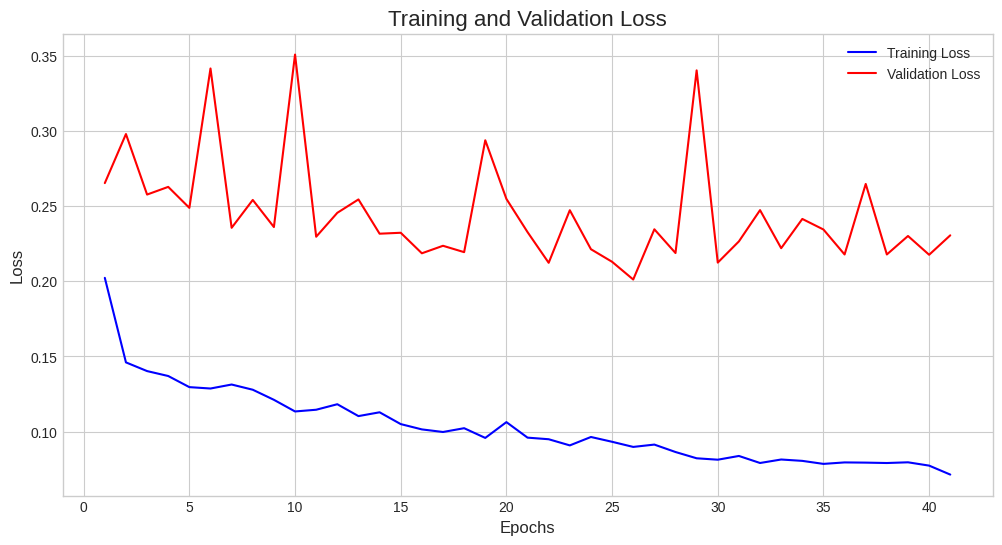

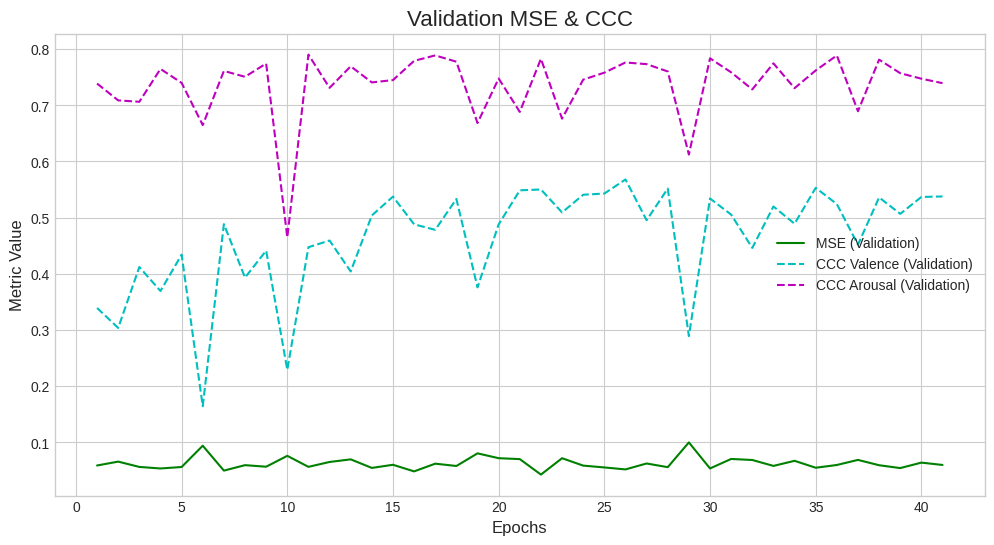

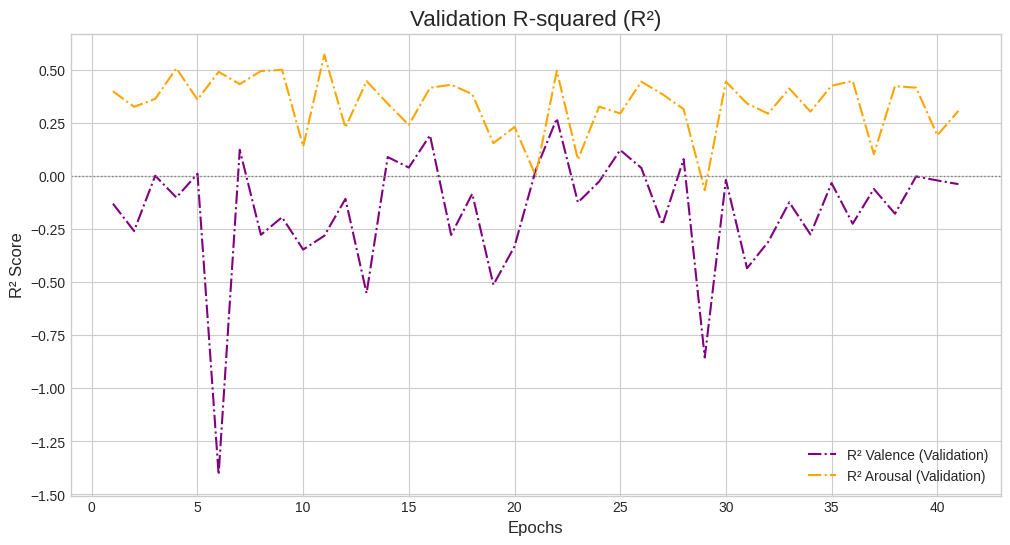

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) 학습 결과 시각화
# ──────────────────────────────────────────────────────────────────────────────
epochs_range = range(1, len(history['train_loss']) + 1)

# --- 1. Train/Val Loss Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 2. MSE / CCC(A/V) Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['mse'], 'g-', label='MSE (Validation)')
plt.plot(epochs_range, history['ccc_val'], 'c--', label='CCC Valence (Validation)')
plt.plot(epochs_range, history['ccc_aro'], 'm--', label='CCC Arousal (Validation)')
plt.title('Validation MSE & CCC', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 3. R^2 Score Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['r2_val'], color='purple', linestyle='-.', label='R² Valence (Validation)')
plt.plot(epochs_range, history['r2_aro'], color='orange', linestyle='-.', label='R² Arousal (Validation)')
plt.axhline(0, color='grey', linestyle=':', linewidth=1) # R²=0 기준선
plt.title('Validation R-squared (R²)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

곡 단위 테스트 데이터 예측을 시작합니다...

== 전체 Test Set 결과 ==
  MSE: 0.1168, MAE: 0.2679
  R2 (V/A): -0.8476 / -0.1114
  CCC (V/A): 0.0793 / 0.4870


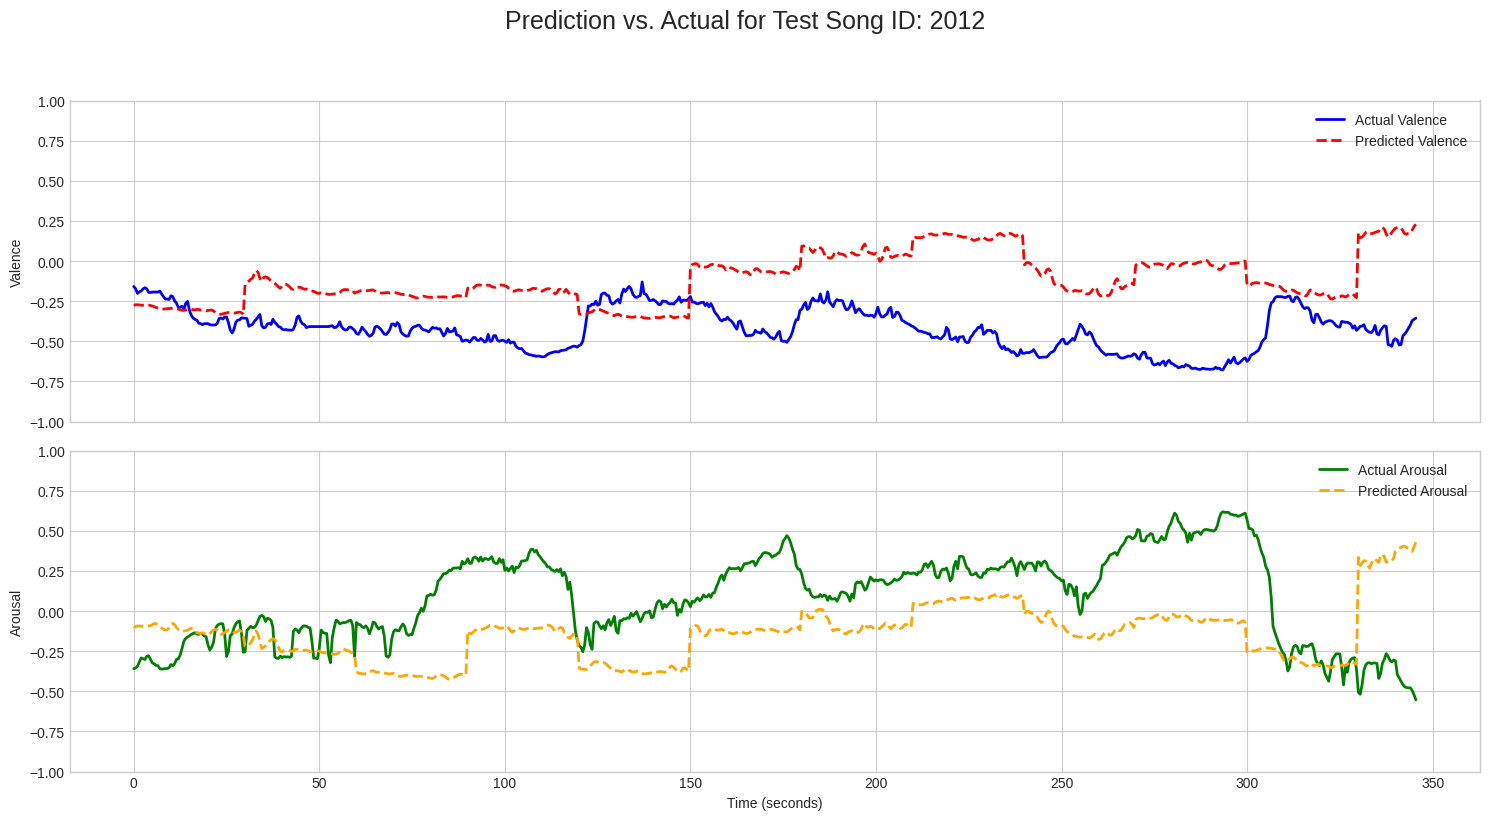


시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import r2_score

# 이전에 정의된 concordance_correlation_coefficient 함수가 필요합니다.
def concordance_correlation_coefficient(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    true_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var = np.var(y_true)
    pred_var = np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)


# ──────────────────────────────────────────────────────────────────────────────
# 1) 모델 로드 및 평가 준비
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load('best_model_mk4.pt'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_song_preds = []
all_song_trues = []

print("곡 단위 테스트 데이터 예측을 시작합니다...")

# ──────────────────────────────────────────────────────────────────────────────
# 2) DataLoader 대신 test_items 리스트를 직접 순회하며 곡 단위로 예측
# ──────────────────────────────────────────────────────────────────────────────
for song_data in test_items:
    # spec_tensor의 모양: [1, 128, T_variable] (채널 차원 유지)
    spec_tensor = song_data['spec']
    ann_tensor = song_data['ann']

    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        # win의 모양: [1, 128, 60] (채널 차원 유지)
        win = spec_tensor[:, :, start:start+60]

        if win.size(-1) < 60:
            pad_size = 60 - win.size(-1)
            win = torch.nn.functional.pad(win, (0, pad_size), "constant", 0)

        windows.append(win)

    if not windows:
        continue

    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    # [최종 수정] torch.cat 대신 torch.stack을 사용하여 올바른 4D 배치 생성
    # [1, 128, 60] 모양의 윈도우 리스트 -> [num_windows, 1, 128, 60] 모양의 4D 텐서
    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    batch = torch.stack(windows, dim=0)

    # stack은 새로운 차원을 생성하므로, 불필요한 차원이 있다면 squeeze()로 제거
    # 현재 `win`의 shape이 [1,128,60]이므로 stack 후 [num_win, 1, 128, 60]이 됨
    # 이 모양이 모델에 정확히 맞으므로 squeeze()는 필요 없습니다.
    batch = batch.to(device)


    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]

    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())


# ──────────────────────────────────────────────────────────────────────────────
# 3) 전체 테스트셋에 대한 평가 지표 계산 및 출력 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────
if all_song_preds:
    preds_flat = np.vstack(all_song_preds)
    trues_flat = np.vstack(all_song_trues)

    mse = np.mean((preds_flat - trues_flat) ** 2)
    mae = np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")
else:
    print("예측 결과가 없습니다.")


# ──────────────────────────────────────────────────────────────────────────────
# 4) 테스트셋의 첫 번째 곡에 대한 결과 시각화 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────

songidid = 11
if all_song_preds:
    preds_to_plot = all_song_preds[songidid]
    trues_to_plot = all_song_trues[songidid]
    time_axis = np.arange(len(preds_to_plot)) * 0.5

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    song_id_to_plot = test_items[songidid]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)

    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence')
    ax1.legend()
    ax1.set_ylim(-1, 1)

    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Arousal')
    ax2.legend()
    ax2.set_ylim(-1, 1)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('song_prediction_visualization.png')
    plt.show()

    print(f"\n시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.")

## 분석결과

--- 분석 준비 단계 ---
모델을 성공적으로 로드했습니다.
분석 결과(JSON)는 '/content/drive/MyDrive/musics' 폴더에 저장됩니다.
--------------------------------------------------
총 19개의 파일을 분석합니다.

'Fun._ We Are Young ft. Janelle Monáe OFFICIAL VIDEO _70k.pt' 분석 중...


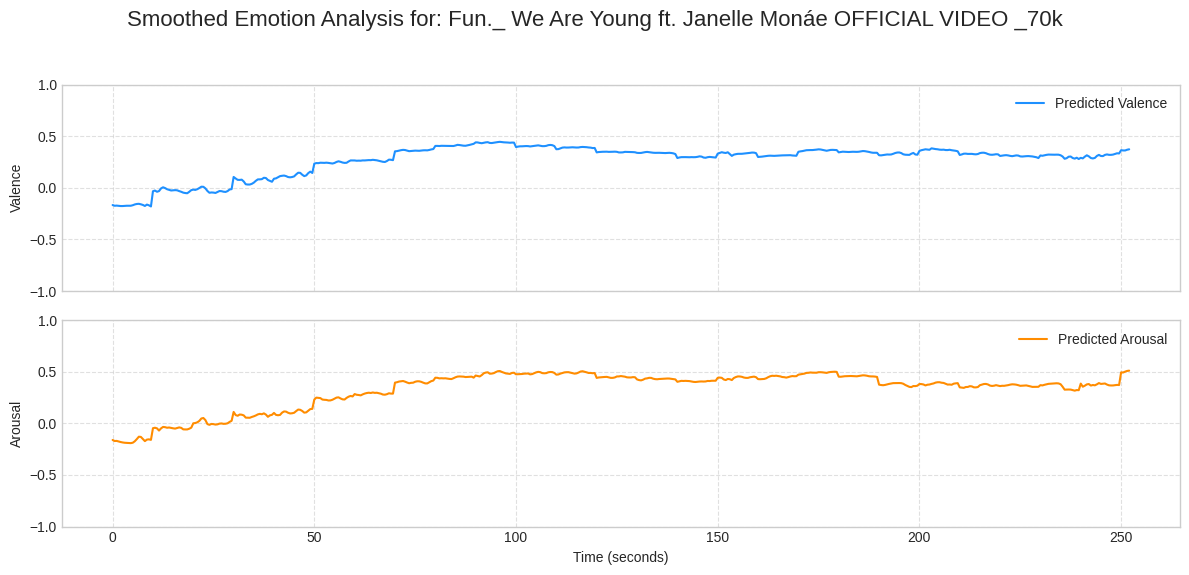

 -> 'Fun._ We Are Young ft. Janelle Monáe OFFICIAL VIDEO _70k.json' 저장 완료.

'The Chainsmokers & Coldplay - Something Just Like This (Lyric)_70k.pt' 분석 중...


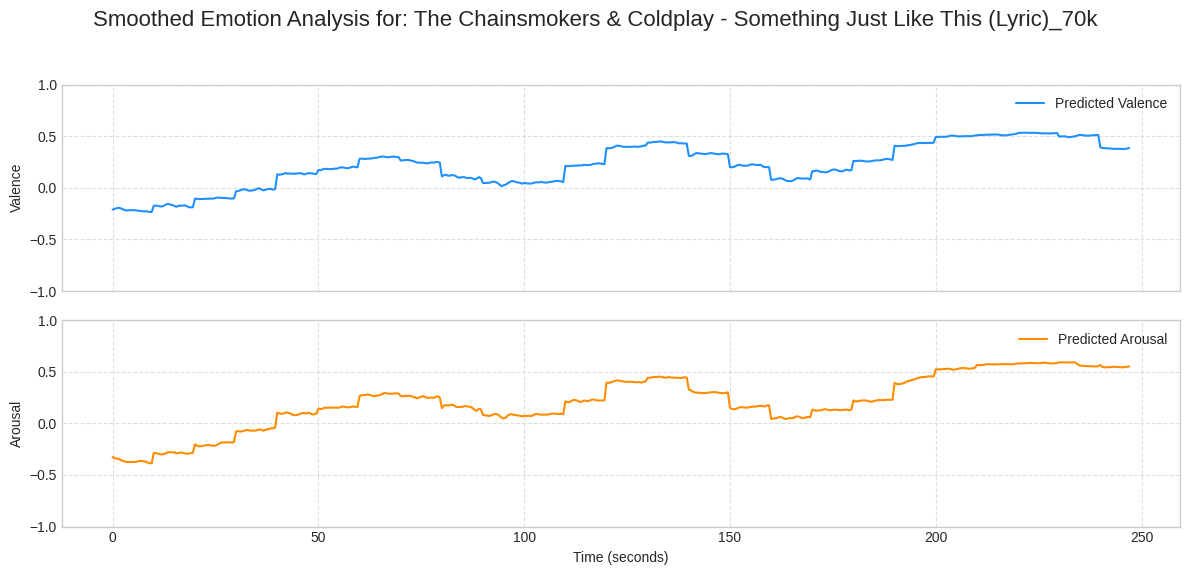

 -> 'The Chainsmokers & Coldplay - Something Just Like This (Lyric)_70k.json' 저장 완료.

'Treasure.pt' 분석 중...


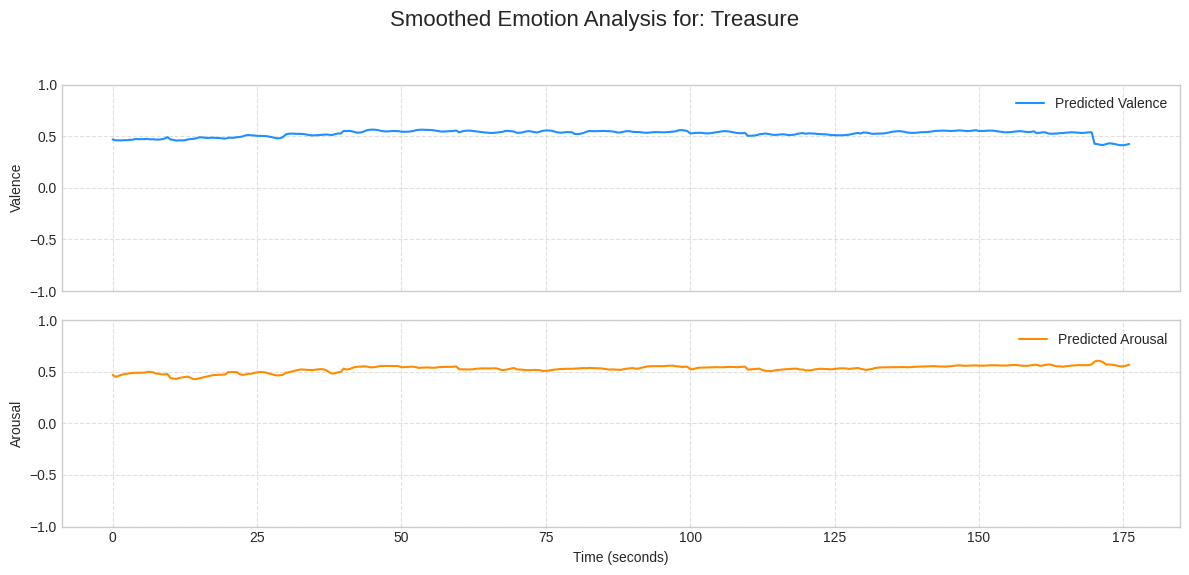

 -> 'Treasure.json' 저장 완료.

'Sia - Chandelier (Official Video)_70k.pt' 분석 중...


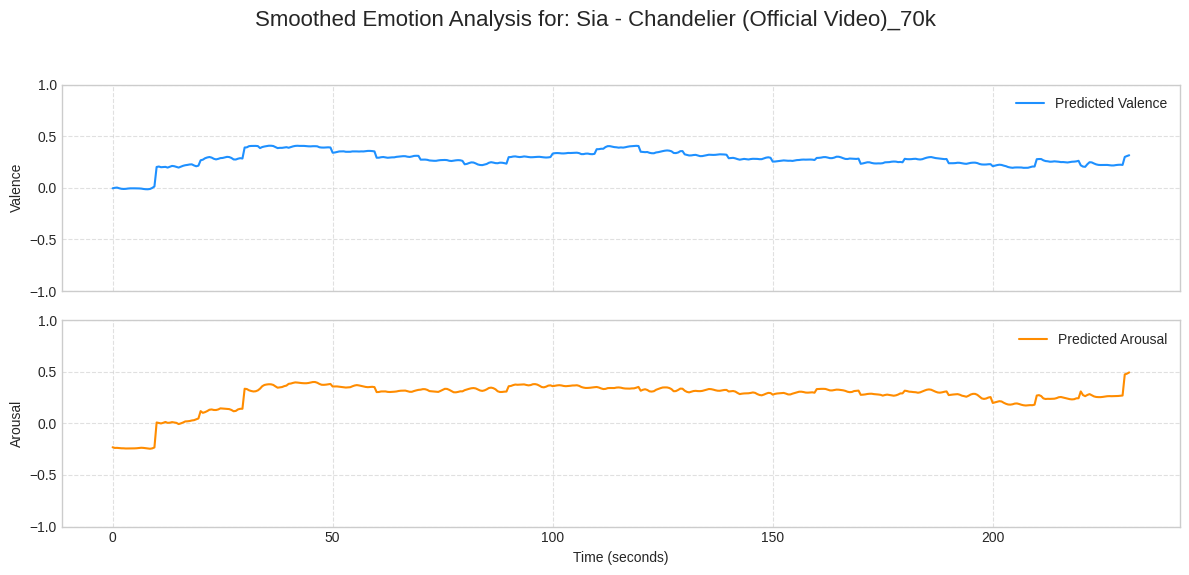

 -> 'Sia - Chandelier (Official Video)_70k.json' 저장 완료.

'Panic! At the Disco - High Hopes (Audio).pt' 분석 중...


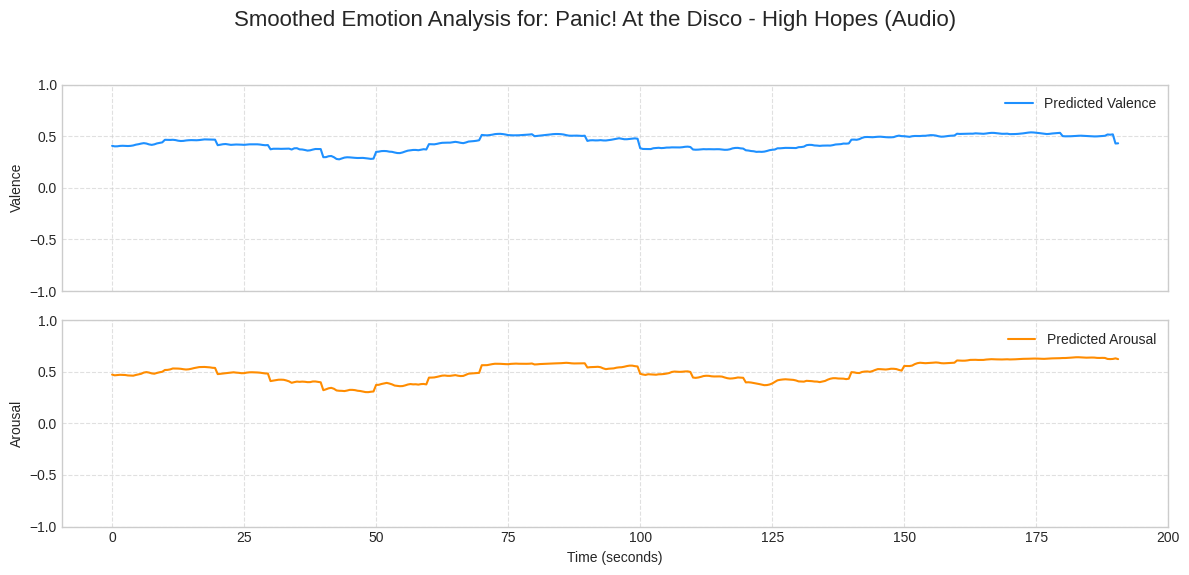

 -> 'Panic! At the Disco - High Hopes (Audio).json' 저장 완료.

'The Weeknd - Blinding Lights (Official Audio).pt' 분석 중...


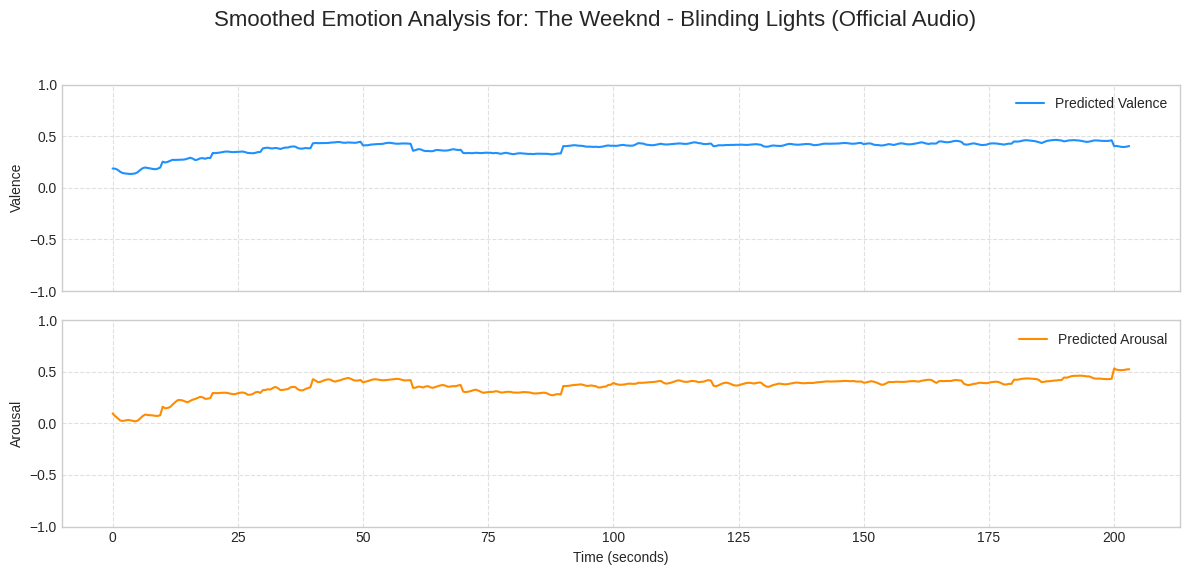

 -> 'The Weeknd - Blinding Lights (Official Audio).json' 저장 완료.

'A Sky Full of Stars.pt' 분석 중...


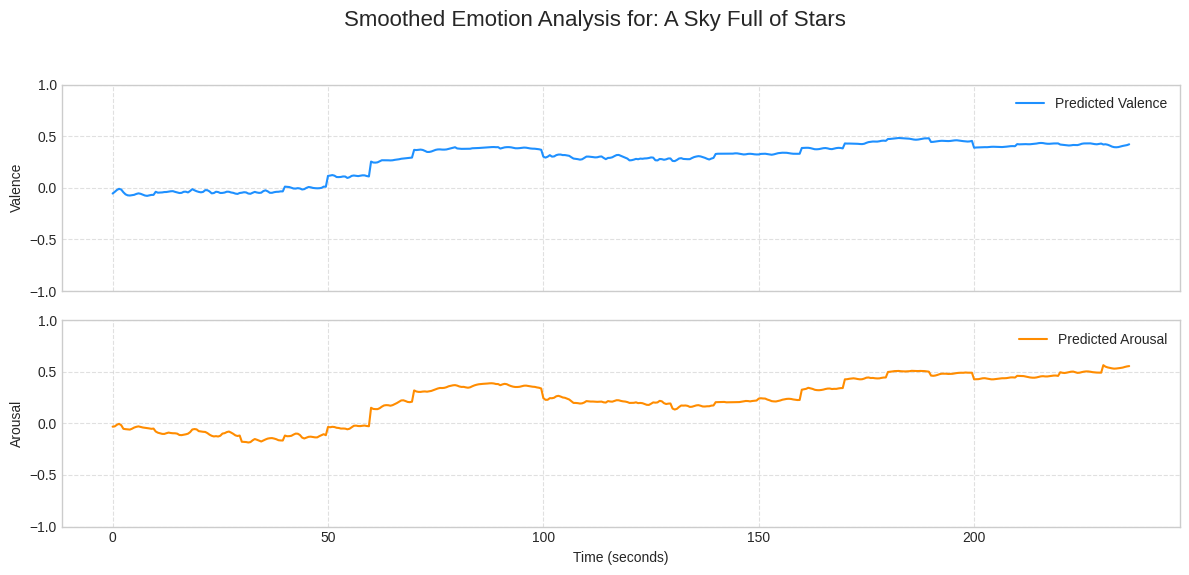

 -> 'A Sky Full of Stars.json' 저장 완료.

'Alan Walker - Faded (Audio).pt' 분석 중...


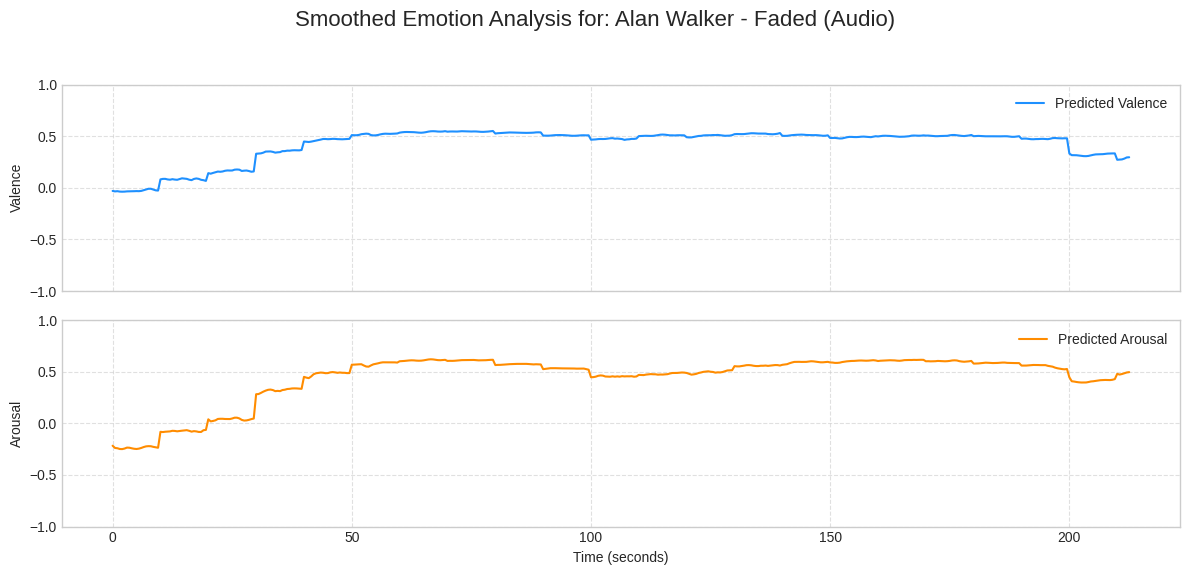

 -> 'Alan Walker - Faded (Audio).json' 저장 완료.

'Imagine Dragons - Radioactive_70k.pt' 분석 중...


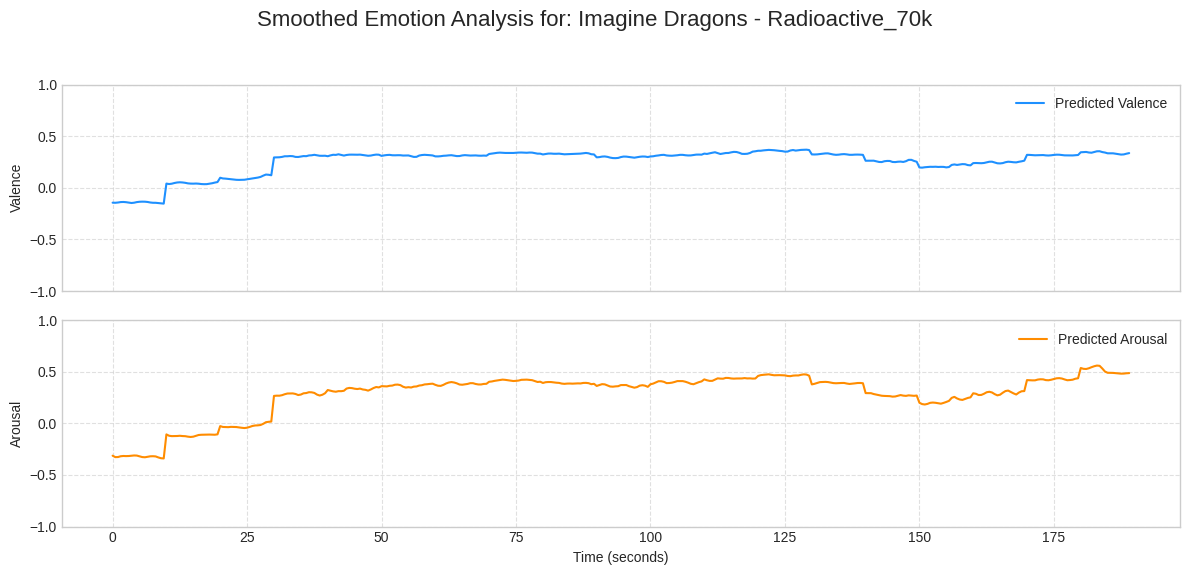

 -> 'Imagine Dragons - Radioactive_70k.json' 저장 완료.

'Taylor Swift - Blank Space_70k.pt' 분석 중...


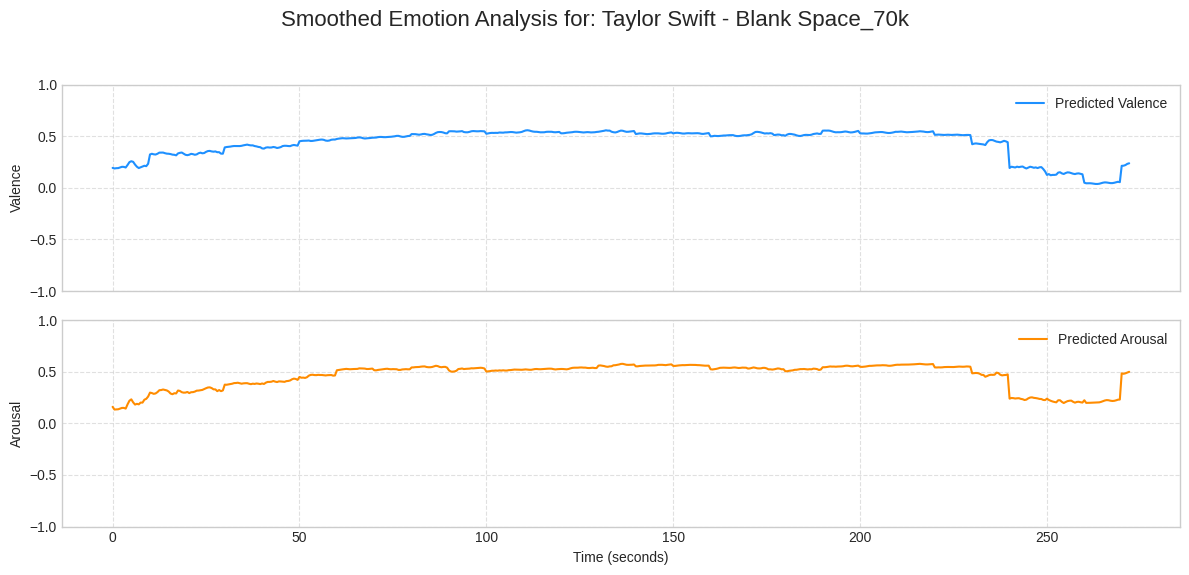

 -> 'Taylor Swift - Blank Space_70k.json' 저장 완료.

'Hymn For The Weekend.pt' 분석 중...


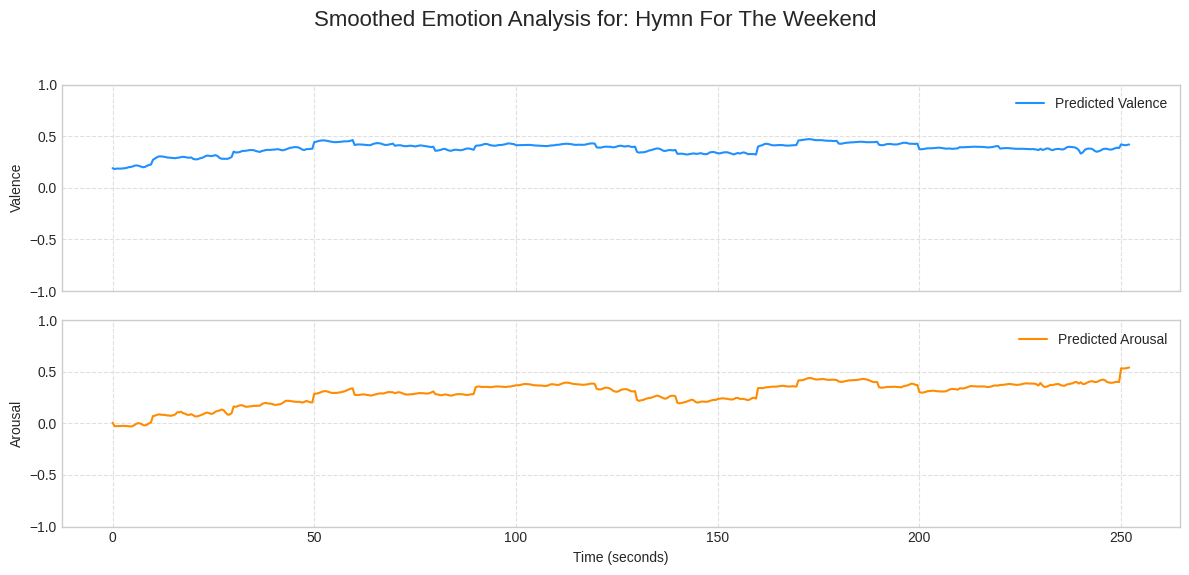

 -> 'Hymn For The Weekend.json' 저장 완료.

'Alan Walker - Faded_70k.pt' 분석 중...


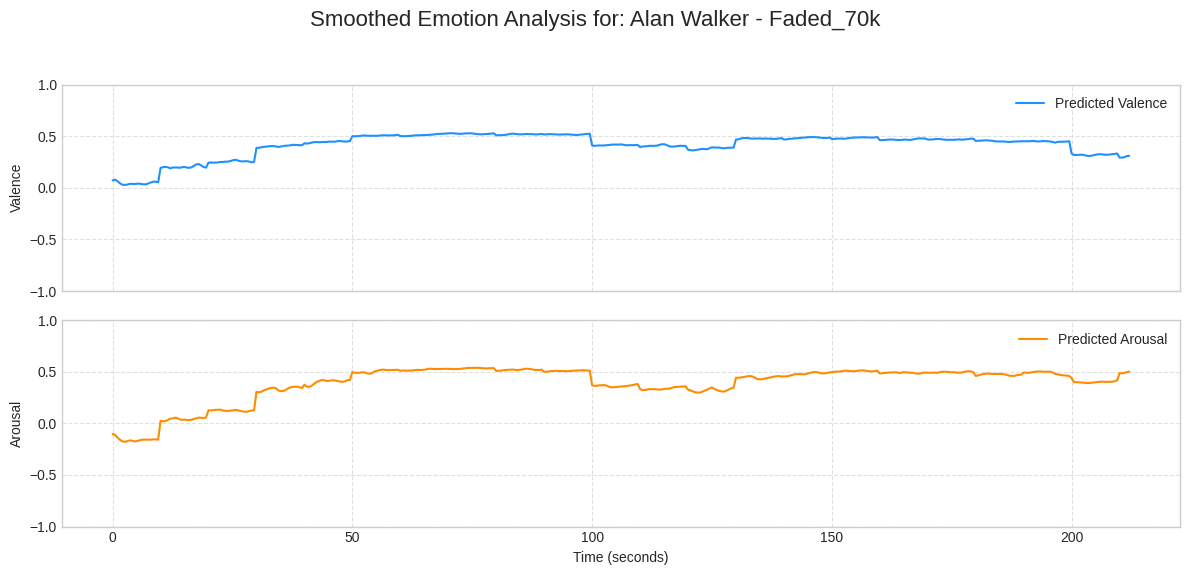

 -> 'Alan Walker - Faded_70k.json' 저장 완료.

'Harry Styles - As It Was (Audio).pt' 분석 중...


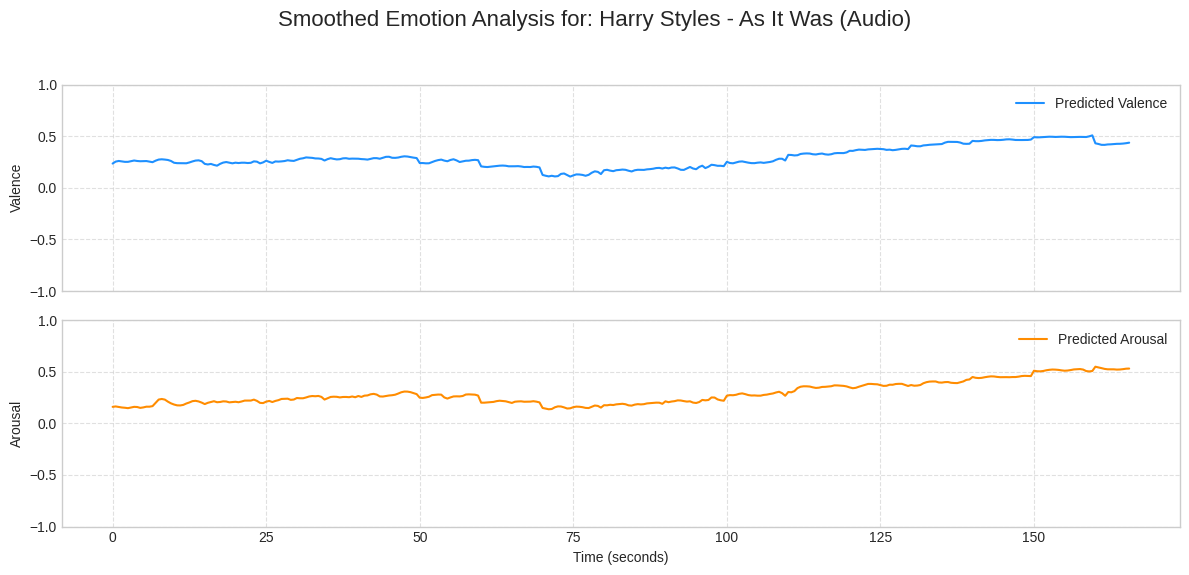

 -> 'Harry Styles - As It Was (Audio).json' 저장 완료.

'Counting Stars.pt' 분석 중...


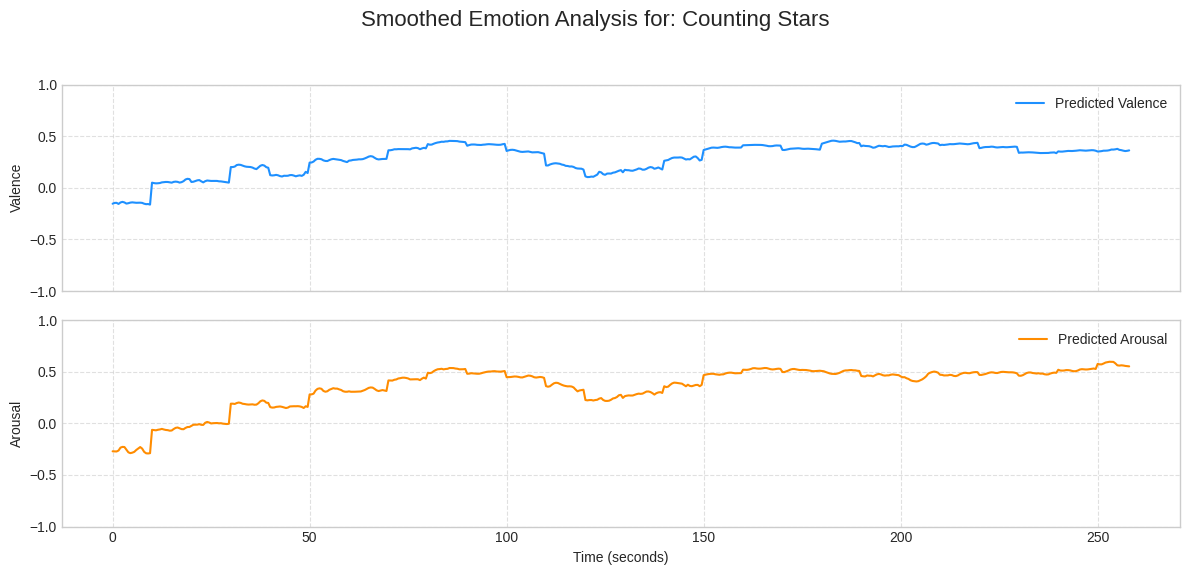

 -> 'Counting Stars.json' 저장 완료.

'Billie Eilish - bad guy (Audio).pt' 분석 중...


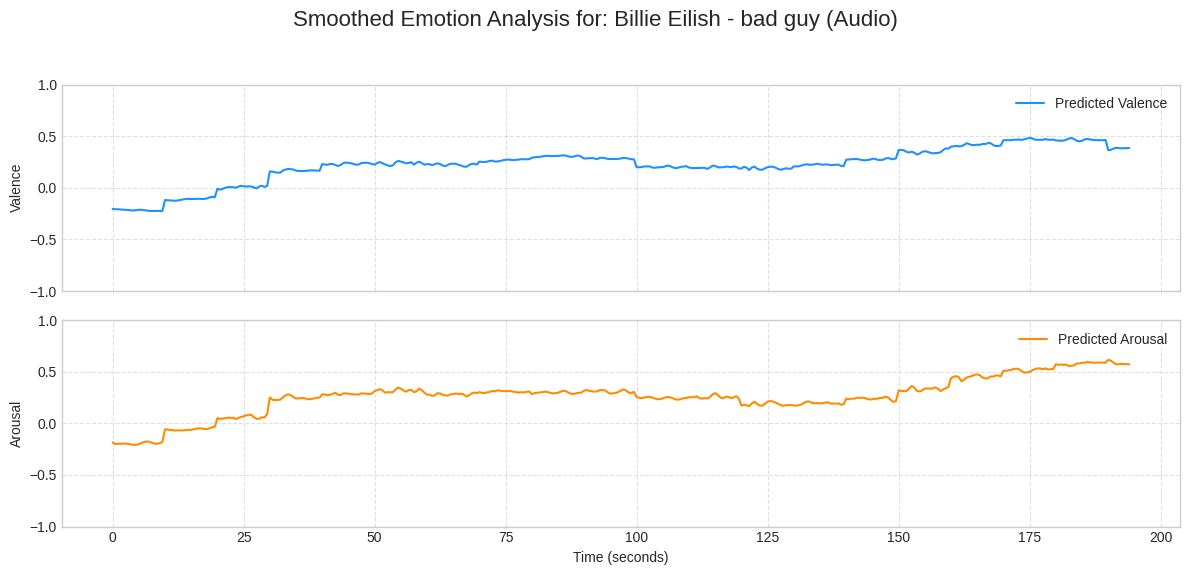

 -> 'Billie Eilish - bad guy (Audio).json' 저장 완료.

'Demons - Imagine Dragons_128k.pt' 분석 중...


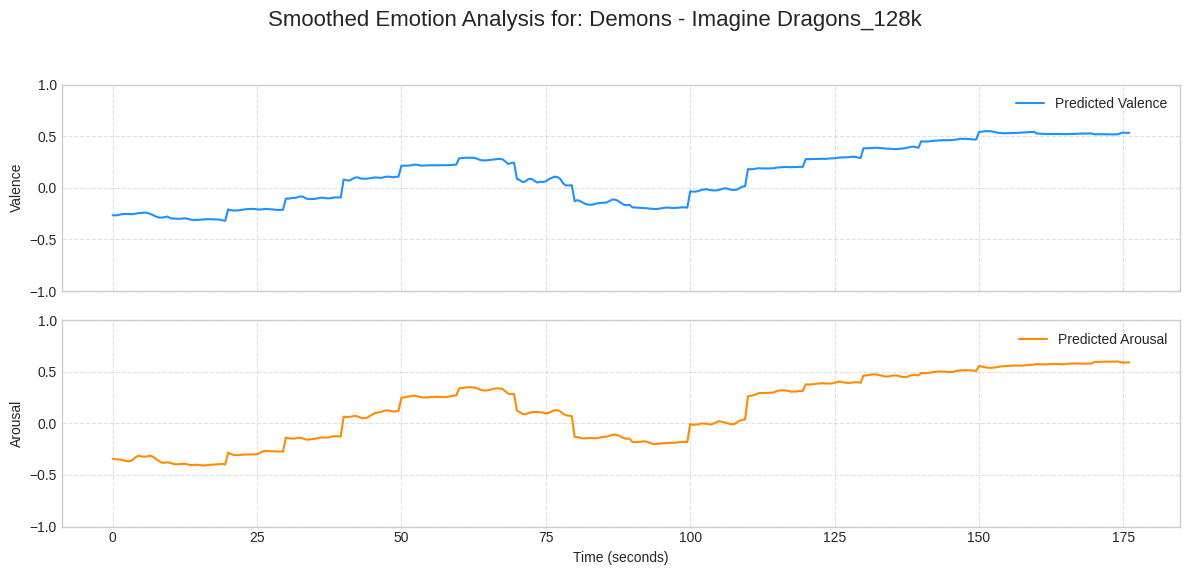

 -> 'Demons - Imagine Dragons_128k.json' 저장 완료.

'Carly Rae Jepsen _Call Me Maybe_ (Official Audio).pt' 분석 중...


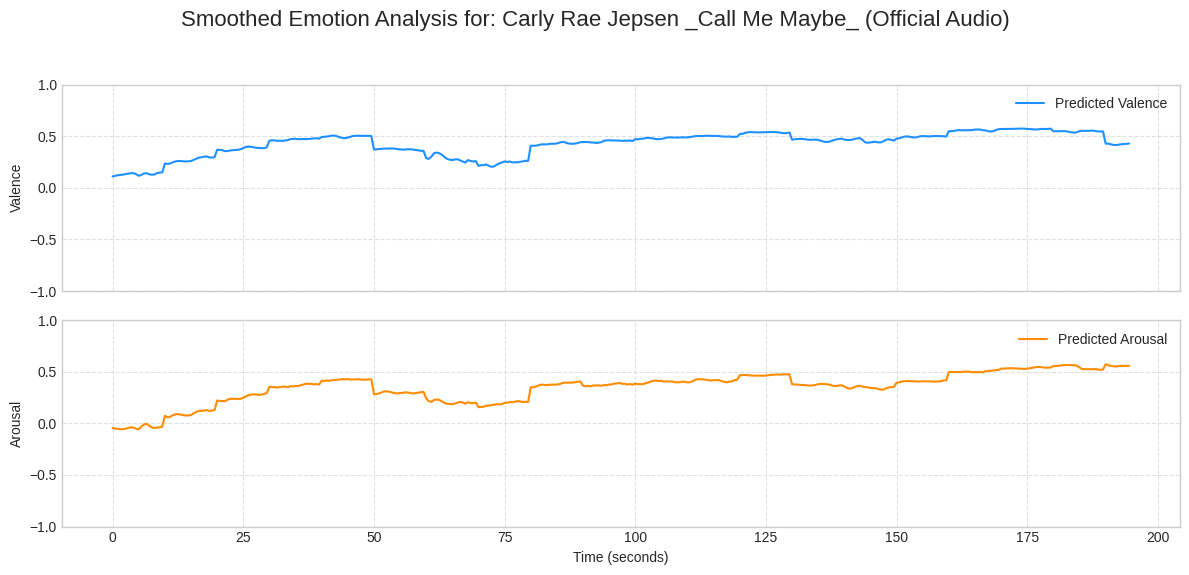

 -> 'Carly Rae Jepsen _Call Me Maybe_ (Official Audio).json' 저장 완료.

'Carly Rae Jepsen - I Really Like You (Audio).pt' 분석 중...


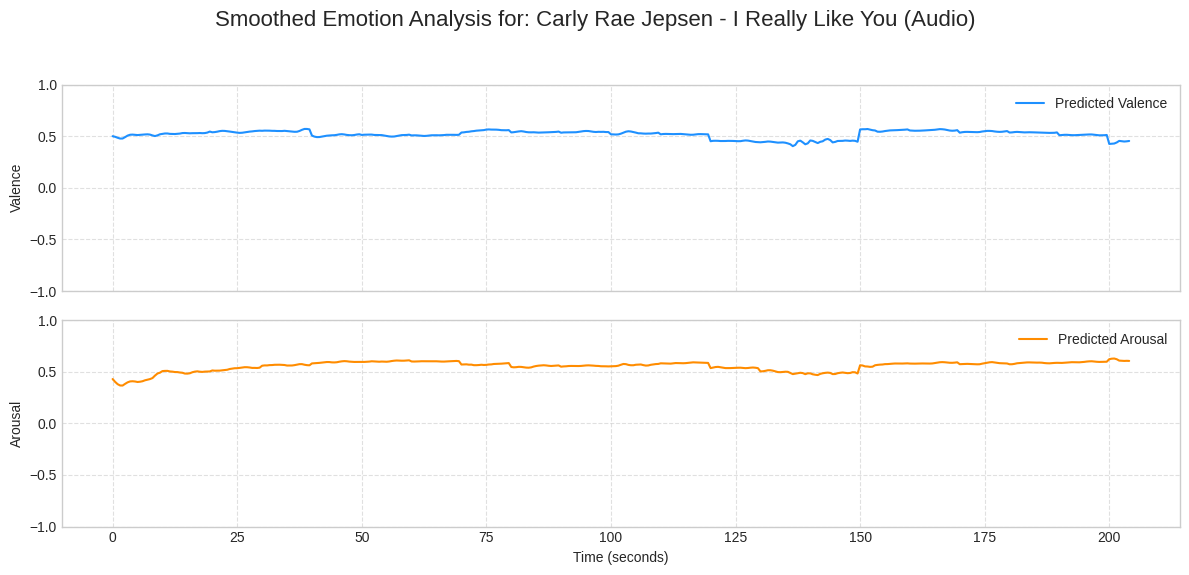

 -> 'Carly Rae Jepsen - I Really Like You (Audio).json' 저장 완료.

'Ed Sheeran - Shape of You (Official Music Video)_70k.pt' 분석 중...


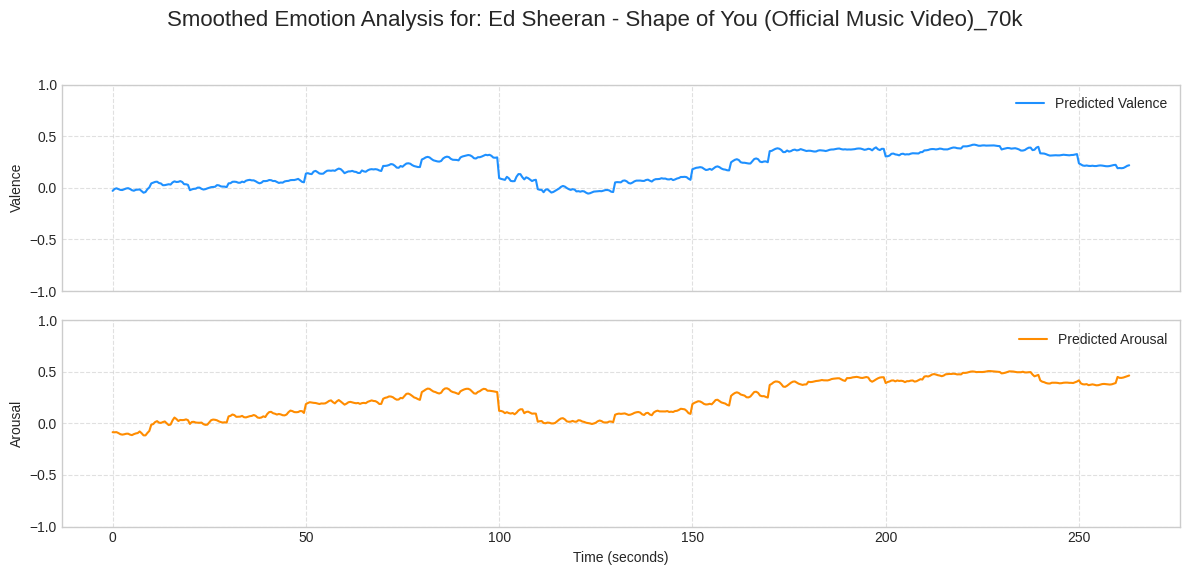

 -> 'Ed Sheeran - Shape of You (Official Music Video)_70k.json' 저장 완료.
--------------------------------------------------

모든 파일 분석 및 저장이 완료되었습니다.


In [ ]:
import torch
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt

# --- 새로운 분석 함수 (Overlapping Window & Averaging) ---
def analyze_song_with_overlap(model, spec_tensor, device):
    """
    Sliding Window 방식을 사용해 스펙트로그램을 분석하고,
    겹치는 부분의 예측값을 평균내어 부드러운 결과를 반환합니다.
    """
    # 파라미터 설정
    window_size_frames = 60  # 모델 입력 크기 (30초)
    step_size_frames = 20    # 윈도우 이동 간격 (10초)

    T = spec_tensor.shape[-1] # 전체 프레임 수

    # 예측값을 누적하고 카운트할 배열 초기화
    sum_predictions = np.zeros((T, 2), dtype=np.float32)
    count_predictions = np.zeros((T, 1), dtype=np.float32)

    # Sliding Window 루프
    for start_frame in range(0, T, step_size_frames):
        end_frame = start_frame + window_size_frames

        # 현재 윈도우 추출
        win_spec = spec_tensor[:, :, start_frame:end_frame]

        # 마지막 윈도우가 60프레임보다 작으면 패딩 추가
        actual_len = win_spec.size(-1)
        if actual_len < window_size_frames:
            pad_size = window_size_frames - actual_len
            win_spec = torch.nn.functional.pad(win_spec, (0, pad_size), "constant", 0)

        # 모델 예측 (배치 차원 추가)
        with torch.no_grad():
            win_out = model(win_spec.unsqueeze(0).to(device))

        preds_window = win_out.cpu().numpy().squeeze(0) # (60, 2) 형태

        # 원본 길이에 해당하는 부분만 누적
        effective_preds = preds_window[:actual_len]
        sum_predictions[start_frame:start_frame + actual_len] += effective_preds
        count_predictions[start_frame:start_frame + actual_len] += 1

    # 평균 계산 (0으로 나누는 것 방지)
    count_predictions[count_predictions == 0] = 1
    final_preds = sum_predictions / count_predictions

    return final_preds


# --- 분석 준비 단계 (이전과 동일) ---
print("--- 분석 준비 단계 ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
try:
    base_cnn = FeatureExtractorCNN()
    model = EmotionModel2(base_cnn).to(device)
    model.load_state_dict(torch.load('best_model_mk4.pt', map_location=device))
    model.eval()
    print("모델을 성공적으로 로드했습니다.")
except NameError:
    print("오류: 모델 클래스를 먼저 정의하고 실행해주세요.")
    raise

# --- 경로 설정 (이전과 동일) ---
preprocessed_dir = "/content/drive/MyDrive/musics"
analysis_output_dir = "/content/drive/MyDrive/musics"
os.makedirs(analysis_output_dir, exist_ok=True)
print(f"분석 결과(JSON)는 '{analysis_output_dir}' 폴더에 저장됩니다.")
print("-" * 50)


# --- 파일 처리, 분석 및 시각화 (메인 루프 수정) ---
pt_files = glob.glob(os.path.join(preprocessed_dir, "*.pt"))

if not pt_files:
    print(f"분석할 .pt 파일을 '{preprocessed_dir}' 폴더에서 찾을 수 없습니다.")
else:
    print(f"총 {len(pt_files)}개의 파일을 분석합니다.")

    for pt_path in pt_files:
        try:
            # 1. 데이터 로드
            song_data = torch.load(pt_path, map_location=device)
            spec_tensor = song_data['spectrogram']
            song_id = song_data['song_id']
            print(f"\n'{song_id}.pt' 분석 중...")

            # 2. ★★★ Overlapping 분석 함수 호출 ★★★
            preds_song = analyze_song_with_overlap(model, spec_tensor, device)

            # 3. 분석 결과 시각화 (이하 동일)
            time_axis = np.arange(len(preds_song)) * 0.5
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
            fig.suptitle(f'Smoothed Emotion Analysis for: {song_id}', fontsize=16)

            ax1.plot(time_axis, preds_song[:, 0], label='Predicted Valence', color='dodgerblue')
            ax1.set_ylabel('Valence')
            ax1.legend(loc='upper right')
            ax1.set_ylim(-1, 1)
            ax1.grid(True, linestyle='--', alpha=0.6)

            ax2.plot(time_axis, preds_song[:, 1], label='Predicted Arousal', color='darkorange')
            ax2.set_xlabel('Time (seconds)')
            ax2.set_ylabel('Arousal')
            ax2.legend(loc='upper right')
            ax2.set_ylim(-1, 1)
            ax2.grid(True, linestyle='--', alpha=0.6)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            # 4. JSON 데이터 구성 (이하 동일)
            time_series_va = []
            for i, (valence, arousal) in enumerate(preds_song):
                timestamp_ms = i * 500
                time_series_va.append({
                    "timestamp_ms": timestamp_ms,
                    "valence": round(float(valence), 4),
                    "arousal": round(float(arousal), 4)
                })

            result_json = {
                "song_title": song_id,
                "time_series_va": time_series_va
            }

            # 5. JSON 파일로 저장 (이하 동일)
            json_filename = f"{song_id}.json"
            json_save_path = os.path.join(analysis_output_dir, json_filename)

            with open(json_save_path, 'w', encoding='utf-8') as f:
                json.dump(result_json, f, indent=2, ensure_ascii=False)

            print(f" -> '{json_filename}' 저장 완료.")

        except Exception as e:
            print(f" -> 오류: '{os.path.basename(pt_path)}' 파일 처리 중 문제가 발생했습니다. ({e})")

    print("-" * 50)
    print("\n모든 파일 분석 및 저장이 완료되었습니다.")